In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.TwoDoF as TwoDof

from matplotlib.lines import Line2D
import multiprocessing as mp

me.mechanics_printing()

In [2]:
def Find_Fixed_Points():   
    dataset_name = 'Test'
    # Set JEC Specific parameters
    sm = mf.SymbolicModel.from_file('2DoF_Model.py')
    p = TwoDof.base_params()
    
    p.rho.value = 0.0885
    p.s.value = 5.8
    p.c_root.value = 3.71
    p.c_tip.value = 2.137
    p.m.value = 943*0.66
    p.m_w.value = 2040
    p.f_0.value = 2
    
    p.k_w.value = (p.f_0.value*2*np.pi)**2*(p.m_w.value+p.m.value)             # Stiffness of the inner wing
    p.I_xx.value = 1/12*p.m.value*p.s.value**2          # FWT polar moment of inetia
    p.I_xx.value = 6.5/81*p.m.value*p.s.value**2 
    p.l_com.value = p.s.value/3
   
    vars_ls =[]
    vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
    vars_ls.append((p.c_d_max,[0,1]))
    vars_ls.append((p.k_fwt,[0,1e8]))
    vars_ls.append((p.V,[188]))
    vars_ls.append((p.Lambda,np.deg2rad([25])))

    variables = [k for k,v in vars_ls]
    
    fp_df = rw.fixed_point_finder(p,sm,vars_ls,False)
    #if save_mini_model:      
    #    sm_mini = sm.msubs(p.GetSubs(0,None,ignore=variables+[p.w_g]))
    #    sm_mini.to_file(f'Temp_{dataset_name}_mini_M{model_num}_{b_modes}B{t_modes}T.py')
    #fp_df['Model'] = model_num
    #fp_df['Config'] = dataset_name
    return fp_df

In [3]:
df = Find_Fixed_Points()
df['Coast Angle [Deg]'] = (np.rad2deg([i[-1] for i in df['q']]))
df

,alpha_r,C_Dmax,k_fwt,V,Lambda,q,Coast Angle [Deg]
0,0.000000,0.0,0.0,188.0,0.436332,"[-0.05250123585848669, 0.07894068798955317]",4.522968
1,0.000000,1.0,0.0,188.0,0.436332,"[-0.052501214694698144, 0.0789267832588925]",4.522172
2,0.087266,0.0,0.0,188.0,0.436332,"[-0.0525961618171506, -0.12692471045780346]",-7.272250
3,0.087266,1.0,0.0,188.0,0.436332,"[-0.05259619508822848, -0.12693839399883114]",-7.273034
4,0.174533,0.0,0.0,188.0,0.436332,"[-0.05342809800467127, -0.32499301637775085]",-18.620728
5,0.174533,1.0,0.0,188.0,0.436332,"[-0.05342816552220849, -0.3250045398993019]",-18.621388
6,0.000000,0.0,100000000.0,188.0,0.436332,"[-0.062108120153447306, 0.00011786464731159772]",0.006753
7,0.000000,1.0,100000000.0,188.0,0.436332,"[-0.062108120153441394, 0.00011786464731152897]",0.006753
8,0.087266,0.0,100000000.0,188.0,0.436332,"[-0.0369603262527375, -0.0001887463092773241]",-0.010814
9,0.087266,1.0,100000000.0,188.0,0.436332,"[-0.03692992941170299, -0.00018911691853447528]",-0.010836


In [4]:
p = TwoDof.base_params()
aoa = mf.GetAoA(p.alpha_r+p.w_g/p.V,0,p.Lambda,p.q[1])
aoa_func = sym.lambdify((p.GetTuple(),p.x),aoa)
aoa_code = "def get_aoa():\n\t"+sym.printing.python(aoa).replace('\n','\n\t')+"\n\treturn e\n"
full_code = "from sympy import *\n"+aoa_code

# Save to the file
t_file = open('aoa.py',"w")
n = t_file.write(full_code)
t_file.close() 

import importlib.util


def GustTimeResponse(gust_strength,gust_period,fp_dict,att_index,end_time):
    sm = mf.SymbolicModel.from_file('2DoF_Model.py')
    p = TwoDof.base_params()
    
    p.rho.value = 0.0885
    p.s.value = 5.8
    p.c_root.value = 3.71
    p.c_tip.value = 2.137
    p.m.value = 943*0.66
    p.m_w.value = 2040
    p.f_0.value = 2
    
    p.k_w.value = (p.f_0.value*2*np.pi)**2*(p.m_w.value+p.m.value)             # Stiffness of the inner wing
    p.I_xx.value = 1/12*p.m.value*p.s.value**2          # FWT polar moment of inetia
    p.I_xx.value = 6.5/81*p.m.value*p.s.value**2 
    p.l_com.value = p.s.value/3
      
    nm = sm.CreateNumericModel(p)
    
    gust_strength = 13.4*(188*gust_period/(2*106.16))**(1/6)
    
    # set attitude parameters
    tup = p.GetTuple()
    for k,v in fp_dict.items():
        for s in tup:
            if isinstance(s,mf.ModelSymbol):
                if s.name == k:
                    s.value = v

    #Define the Gust Function
    def gust(t,x):
        if t<gust_period:
            return gust_strength*0.5*(1- np.cos(2*np.pi*t/gust_period))
        else:
            return 0
    p.w_g.value = gust
    
    # Define Objective Function for solver
    def objectiveDeriv(t,y):
        tup = p.GetNumericTuple(y,t)
        return nm.deriv(t,y,tup)

    # Generate I.C. and run the solver
    x = [0]*p.qs*2
    x[::2] = fp_dict['q']
    yData = solve_ivp(objectiveDeriv,(0,end_time),x,max_step=0.01)

    #interpolate to reduce t and y points
    int_func = interp1d(yData.t,yData.y)

    t = np.linspace(0,end_time,(end_time*100)+1)
    yi = int_func(t)
    
    
    #Package Results
    # remove q from dict
    var = {k:v for k,v in fp_dict.items() if k !='q'}
    
    # Calculate local AoA
    spec = importlib.util.spec_from_file_location("my.Model", 'aoa.py')
    m = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(m)
    aoa = m.get_aoa()

    aoa_func = sym.lambdify((p.GetTuple(),p.x),aoa)
    
    #Calc Lift + fold Angles
    zero_lift = 0
    Lift = []
    Delta_Lift = []
    aoas=[]
    Fold = np.rad2deg(yi[2,:])
    for i in range(len(t)):
        lift = nm.ExtForces(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i],t[i])[0,0]
        aoas.append(aoa_func(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i]))
        if i == 0:
            zero_lift = lift
        Lift.append(lift)
        Delta_Lift.append(lift - zero_lift)
        #Fold.append(np.rad2deg(fold))
    aoas = np.rad2deg(aoas)
    
    # Calculate peak Delta Lift
    max_delta_lift = np.max(Delta_Lift)
    min_delta_lift = np.min(Delta_Lift)
    
    #populate list of data
    ls = []        
    for i in range(len(t)):
        ls.append({'t':t[i],'q':yi[:,i],'Gust Strength':gust_strength,
                   'Gust Period':gust_period,**var,'Attitude':att_index,
                  'Lift [N]':Lift[i],'Delta Lift [N]':Delta_Lift[i],
                   'Fold Angle [Deg]':Fold[i],'Max lift [N]':max_delta_lift,
                  'Min Lift [N]':min_delta_lift,'Local AoA [Deg]':aoas[i]})
    print(f'Completed attitude {att_index},gust strength {gust_strength}, gust period {gust_period}')
    return ls

In [5]:
%%time
i=0
row = df.iloc[i]
ls = GustTimeResponse(20,1,row.to_dict(),i,4)

Completed attitude 0,gust strength 13.131044979717974, gust period 1
CPU times: user 1.45 s, sys: 7.92 ms, total: 1.45 s
Wall time: 1.46 s


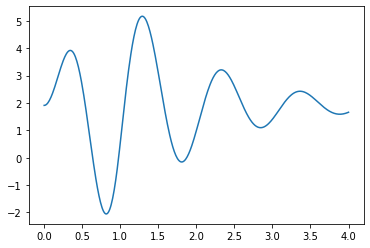

In [6]:
singleGustDf=pd.DataFrame(ls)
#singleGustDf['Fold Angle [Deg]'] = np.rad2deg([i[2] for i in singleGustDf['q']])
#singleGustDf['Lift'] = np.rad2deg([i[0] for i in singleGustDf['q']])
plt.plot(singleGustDf['t'],singleGustDf['Local AoA [Deg]'])

In [7]:
data = df.copy()

w_max = [10]
w_T = [0.2,1,2]
w_T = np.linspace(0.2,3,15)
w_T = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]


pool = mp.Pool(mp.cpu_count())

res =[]
for T in w_T:
    for M in w_max:
        for i in range(len(data)):
            row = data.iloc[i]
            res.append(pool.apply_async(GustTimeResponse, args = (M,T,row.to_dict(),i,4)))

pool.close()
pool.join()


ls = []
for i in res:
    ls += i.get()
gust_df = pd.DataFrame(ls)
print('Complete')

Completed attitude 2,gust strength 8.946076803125212, gust period 0.1
Completed attitude 0,gust strength 8.946076803125212, gust period 0.1
Completed attitude 5,gust strength 8.946076803125212, gust period 0.1
Completed attitude 1,gust strength 8.946076803125212, gust period 0.1
Completed attitude 4,gust strength 8.946076803125212, gust period 0.1
Completed attitude 3,gust strength 8.946076803125212, gust period 0.1
Completed attitude 7,gust strength 8.946076803125212, gust period 0.1
Completed attitude 6,gust strength 8.946076803125212, gust period 0.1
Completed attitude 1,gust strength 10.041631692768894, gust period 0.2
Completed attitude 0,gust strength 10.041631692768894, gust period 0.2
Completed attitude 8,gust strength 8.946076803125212, gust period 0.1
Completed attitude 9,gust strength 8.946076803125212, gust period 0.1
Completed attitude 2,gust strength 10.041631692768894, gust period 0.2
Completed attitude 11,gust strength 8.946076803125212, gust period 0.1
Completed attitu

In [9]:
gust_df.to_pickle('Gust_data.pkl')

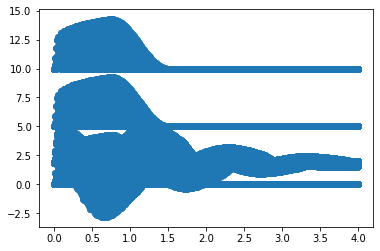

In [10]:
dat=gust_df.copy()
plt.plot(dat['t'],dat['Local AoA [Deg]'],'o')
